In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.autograd import Variable

from utils import mnist, plot_graphs, plot_mnist
import numpy as np

%matplotlib inline

In [2]:
mnist_transform = transforms.Compose([
                transforms.ToTensor(),
                transforms.Normalize((0.5,), (0.5,)),
           ])
train_loader, valid_loader, test_loader = mnist(valid=10000, transform=mnist_transform, batch_size=64)

In [3]:
class Encoder(nn.Module):
    def __init__(self, latent_size=10):
        super(Encoder, self).__init__()
        self.fc1 = nn.Linear(28*28, 256)
        self.fc2 = nn.Linear(256, latent_size)
    
    def forward(self, x):
        x = F.tanh(self.fc1(x))
        x = F.tanh(self.fc2(x))
        return x
    
class Decoder(nn.Module):
    def __init__(self, latent_size=10):
        super(Decoder, self).__init__()
        self.fc1 = nn.Linear(latent_size, 256)
        self.fc2 = nn.Linear(256, 28*28)
    
    def forward(self, x):
        x = F.tanh(self.fc1(x))
        x = F.tanh(self.fc2(x))
        return x

In [4]:
class Net(nn.Module):
    def __init__(self, latent_size=10, loss_fn=F.mse_loss, lr=1e-4, l2=0.):
        super(Net, self).__init__()
        self.latent_size = latent_size
        self.E = Encoder(latent_size)
        self.D = Decoder(latent_size)
        self.loss_fn = loss_fn
        self._rho_loss = None
        self._loss = 0.    
        self.optim = optim.Adam(self.parameters(), lr=lr, weight_decay=l2)
             
        
    def forward(self, x):
        x = x.view(-1, 28*28)
        h = self.E(x)
        self.data_rho = h.mean(0)
        out = self.D(h)
        return out
    
    def decode(self, h):
        with torch.no_grad():
            return self.D(h)
    
    def rho_loss(self, rho, size_average=True):
        
        size = self.data_rho.shape[0]
        rho_vec = rho * torch.ones(size)
        
        #l1_loss = nn.L1Loss()
        #print ("\ndata_rho=", self.data_rho)
        #print ("rho_vec=", rho_vec)
        self._rho_loss = 100 * F.l1_loss(self.data_rho, rho_vec)
        
        
        return self._rho_loss
    
    def loss(self, x, target, **kwargs):
        target = target.view(-1, 28*28)
        self._loss = self.loss_fn(x, target, **kwargs)
        return self._loss
   
   

In [5]:
models = {'64': Net(64)}
rho = 1/64
train_log = {k: [] for k in models}
test_log = {k: [] for k in models}

In [6]:
def train(epoch, models, log=None):
    train_size = len(train_loader.sampler)
    for batch_idx, (data, _) in enumerate(train_loader):
        for model in models.values():
            model.optim.zero_grad()
            output = model(data)
            rho_loss = model.rho_loss(rho)
            loss = model.loss(output, data) + rho_loss
            #print ("rho_loss=", rho_loss)
            loss.backward()
            model.optim.step()
            
        if batch_idx % 200 == 0:
            line = 'Train Epoch: {} [{}/{} ({:.0f}%)]\tLosses '.format(
                epoch, batch_idx * len(data), train_size, 100. * batch_idx / len(train_loader))
            losses = ' '.join(['{}: {:.6f}'.format(k, m._loss.item()) for k, m in models.items()])
            print(line + losses)
            
    else:
        batch_idx += 1
        line = 'Train Epoch: {} [{}/{} ({:.0f}%)]\tLosses '.format(
            epoch, batch_idx * len(data), train_size, 100. * batch_idx / len(train_loader))
        losses = ' '.join(['{}: {:.6f}'.format(k, m._loss.item()) for k, m in models.items()])
        if log is not None:
            for k in models:
                log[k].append((models[k]._loss, models[k]._rho_loss))
        print(line + losses)

In [7]:
avg_lambda = lambda l: 'loss: {:.4f}'.format(l)
rho_lambda = lambda p: 'pho_loss: {:.10f}'.format(p)
line = lambda i, l, p: '{}: '.format(i) + avg_lambda(l) + '\t' + rho_lambda(p)
    
def test(models, loader, log=None):
    test_size = len(loader.sampler)


    test_loss = {k: 0. for k in models}
    pho_loss = {k: 0. for k in models}
    with torch.no_grad():
        for data, _ in loader:
            output = {k: m(data) for k, m in models.items()}
            for k, m in models.items():
                test_loss[k] += m.loss(output[k], data, size_average=False).item() # sum up batch loss
                pho_loss[k] += m.rho_loss(rho)
               #print ("test_rho_loss=", m.rho_loss(rho))
    
    for k in models:
        test_loss[k] /= (test_size * 784)
        pho_loss[k] /= (test_size * models[k].latent_size)
        if log is not None:
            log[k].append((test_loss[k], pho_loss[k]))
    
    lines = '\n'.join([line(k, test_loss[k], pho_loss[k]) for k in models]) + '\n'
    report = 'Test set:\n' + lines        
    print(report)

In [8]:
for epoch in range(1, 101):
    for model in models.values():
        model.train()
    train(epoch, models, train_log)
    for model in models.values():
        model.eval()
    test(models, valid_loader, test_log)

Train Epoch: 1 [0/50000 (0%)]	Losses 64: 0.932545
Train Epoch: 1 [12800/50000 (26%)]	Losses 64: 0.469986
Train Epoch: 1 [25600/50000 (51%)]	Losses 64: 0.306630
Train Epoch: 1 [38400/50000 (77%)]	Losses 64: 0.273398
Train Epoch: 1 [12512/50000 (100%)]	Losses 64: 0.247388
Test set:
64: loss: 0.2551	pho_loss: 0.0004860653

Train Epoch: 2 [0/50000 (0%)]	Losses 64: 0.258594
Train Epoch: 2 [12800/50000 (26%)]	Losses 64: 0.247085
Train Epoch: 2 [25600/50000 (51%)]	Losses 64: 0.243447
Train Epoch: 2 [38400/50000 (77%)]	Losses 64: 0.223729
Train Epoch: 2 [12512/50000 (100%)]	Losses 64: 0.220379
Test set:
64: loss: 0.2309	pho_loss: 0.0003297830

Train Epoch: 3 [0/50000 (0%)]	Losses 64: 0.246035
Train Epoch: 3 [12800/50000 (26%)]	Losses 64: 0.224969
Train Epoch: 3 [25600/50000 (51%)]	Losses 64: 0.233851
Train Epoch: 3 [38400/50000 (77%)]	Losses 64: 0.220468
Train Epoch: 3 [12512/50000 (100%)]	Losses 64: 0.223149
Test set:
64: loss: 0.2086	pho_loss: 0.0002983723

Train Epoch: 4 [0/50000 (0%)]	Loss

Train Epoch: 26 [25600/50000 (51%)]	Losses 64: 0.116757
Train Epoch: 26 [38400/50000 (77%)]	Losses 64: 0.125237
Train Epoch: 26 [12512/50000 (100%)]	Losses 64: 0.118842
Test set:
64: loss: 0.1221	pho_loss: 0.0000927302

Train Epoch: 27 [0/50000 (0%)]	Losses 64: 0.124924
Train Epoch: 27 [12800/50000 (26%)]	Losses 64: 0.116262
Train Epoch: 27 [25600/50000 (51%)]	Losses 64: 0.117258
Train Epoch: 27 [38400/50000 (77%)]	Losses 64: 0.122392
Train Epoch: 27 [12512/50000 (100%)]	Losses 64: 0.102839
Test set:
64: loss: 0.1194	pho_loss: 0.0001003682

Train Epoch: 28 [0/50000 (0%)]	Losses 64: 0.117041
Train Epoch: 28 [12800/50000 (26%)]	Losses 64: 0.121711
Train Epoch: 28 [25600/50000 (51%)]	Losses 64: 0.123905
Train Epoch: 28 [38400/50000 (77%)]	Losses 64: 0.126529
Train Epoch: 28 [12512/50000 (100%)]	Losses 64: 0.127169
Test set:
64: loss: 0.1229	pho_loss: 0.0000989120

Train Epoch: 29 [0/50000 (0%)]	Losses 64: 0.120885
Train Epoch: 29 [12800/50000 (26%)]	Losses 64: 0.111107
Train Epoch: 29 [25

Train Epoch: 51 [38400/50000 (77%)]	Losses 64: 0.099723
Train Epoch: 51 [12512/50000 (100%)]	Losses 64: 0.121640
Test set:
64: loss: 0.1002	pho_loss: 0.0000806624

Train Epoch: 52 [0/50000 (0%)]	Losses 64: 0.101980
Train Epoch: 52 [12800/50000 (26%)]	Losses 64: 0.102954
Train Epoch: 52 [25600/50000 (51%)]	Losses 64: 0.098116
Train Epoch: 52 [38400/50000 (77%)]	Losses 64: 0.097627
Train Epoch: 52 [12512/50000 (100%)]	Losses 64: 0.093748
Test set:
64: loss: 0.1049	pho_loss: 0.0000933003

Train Epoch: 53 [0/50000 (0%)]	Losses 64: 0.103467
Train Epoch: 53 [12800/50000 (26%)]	Losses 64: 0.101517
Train Epoch: 53 [25600/50000 (51%)]	Losses 64: 0.108541
Train Epoch: 53 [38400/50000 (77%)]	Losses 64: 0.102780
Train Epoch: 53 [12512/50000 (100%)]	Losses 64: 0.109543
Test set:
64: loss: 0.1044	pho_loss: 0.0000867374

Train Epoch: 54 [0/50000 (0%)]	Losses 64: 0.104503
Train Epoch: 54 [12800/50000 (26%)]	Losses 64: 0.098901
Train Epoch: 54 [25600/50000 (51%)]	Losses 64: 0.116818
Train Epoch: 54 [38

Train Epoch: 76 [12512/50000 (100%)]	Losses 64: 0.112731
Test set:
64: loss: 0.1006	pho_loss: 0.0000773479

Train Epoch: 77 [0/50000 (0%)]	Losses 64: 0.099212
Train Epoch: 77 [12800/50000 (26%)]	Losses 64: 0.111806
Train Epoch: 77 [25600/50000 (51%)]	Losses 64: 0.090798
Train Epoch: 77 [38400/50000 (77%)]	Losses 64: 0.090340
Train Epoch: 77 [12512/50000 (100%)]	Losses 64: 0.103321
Test set:
64: loss: 0.1021	pho_loss: 0.0000878298

Train Epoch: 78 [0/50000 (0%)]	Losses 64: 0.091379
Train Epoch: 78 [12800/50000 (26%)]	Losses 64: 0.093588
Train Epoch: 78 [25600/50000 (51%)]	Losses 64: 0.094618
Train Epoch: 78 [38400/50000 (77%)]	Losses 64: 0.093206
Train Epoch: 78 [12512/50000 (100%)]	Losses 64: 0.095994
Test set:
64: loss: 0.1013	pho_loss: 0.0000841481

Train Epoch: 79 [0/50000 (0%)]	Losses 64: 0.101248
Train Epoch: 79 [12800/50000 (26%)]	Losses 64: 0.104478
Train Epoch: 79 [25600/50000 (51%)]	Losses 64: 0.102248
Train Epoch: 79 [38400/50000 (77%)]	Losses 64: 0.099542
Train Epoch: 79 [12

In [9]:
torch.save(models['64'], './model_64_tanh')


/home/aleksey/Programs/anaconda3/envs/otus-dl-engineer/lib/python3.6/site-packages/torch/serialization.py:193: UserWarning: Couldn't retrieve source code for container of type Net. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/aleksey/Programs/anaconda3/envs/otus-dl-engineer/lib/python3.6/site-packages/torch/serialization.py:193: UserWarning: Couldn't retrieve source code for container of type Encoder. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/aleksey/Programs/anaconda3/envs/otus-dl-engineer/lib/python3.6/site-packages/torch/serialization.py:193: UserWarning: Couldn't retrieve source code for container of type Decoder. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


### Вывод результатов

In [10]:
model = torch.load('./model_64_tanh')

In [13]:
data, _ = next(iter(test_loader))
output = model(data)
to_plot = output.view(-1, 1, 28, 28).clamp(0, 1).data.numpy()
decoded = model.decode(torch.eye(64))
dec_to_plot = ((decoded.view(-1, 1, 28, 28)+1)*0.5).clamp(0, 1).data.numpy()
with torch.no_grad():
    encoded = model.E(data.view(-1, 28*28))
    print ("encoded=",encoded)
    print((abs(encoded) > 0.025).sum(1))
    encoded[abs(encoded) < 0.025] = 0.
    decoded_f = model.decode(encoded)
    f_to_plot = ((decoded_f.view(-1, 1, 28, 28)+1)*0.5).clamp(0, 1).data.numpy()

encoded= tensor(1.00000e-02 *
       [[ 1.4943,  1.8656, -1.0165,  ...,  0.7363,  2.4852,  2.5117],
        [-0.2729,  2.3831,  2.0747,  ...,  2.7658,  1.6459,  1.6922],
        [ 2.3136,  0.4770, -0.1930,  ...,  1.2003,  3.3870,  2.9114],
        ...,
        [ 3.3822,  2.4917,  1.5078,  ...,  2.2304,  1.3389,  0.2844],
        [ 2.8068,  3.5143,  1.6397,  ...,  2.9991,  2.5625,  1.0640],
        [ 1.2497,  2.5499,  0.2895,  ...,  2.3832,  0.4432, -0.2819]])
tensor([ 13,  12,  10,  11,  13,  10,  11,  16,  16,  16,  11,  13,
         15,  12,  12,   8,  14,  12,  10,  12,  13,  14,  11,  13,
         10,  14,   9,  15,   6,  15,  12,  15,  13,  16,  15,  11,
         11,  16,   9,  13,  13,  14,  13,   7,  11,   7,  11,   8,
         16,  13,   5,  12,  11,  11,   9,   7,  13,  13,  13,  10,
         11,  15,  13,  13])


Исходные данные


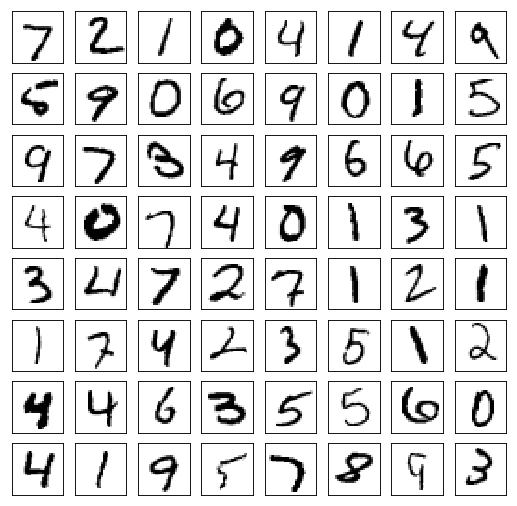

Выход декодера


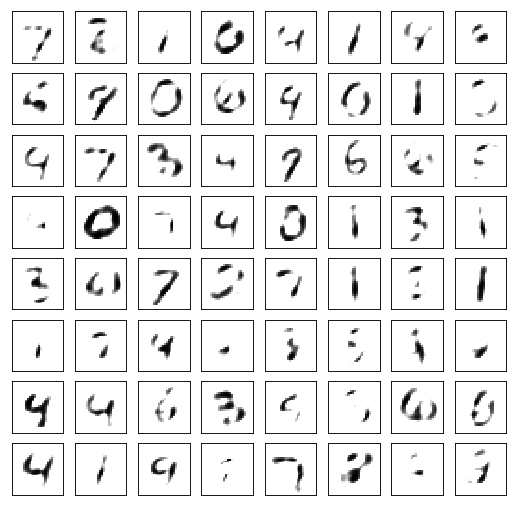

Выход декодера с отсечкой на латентном слое


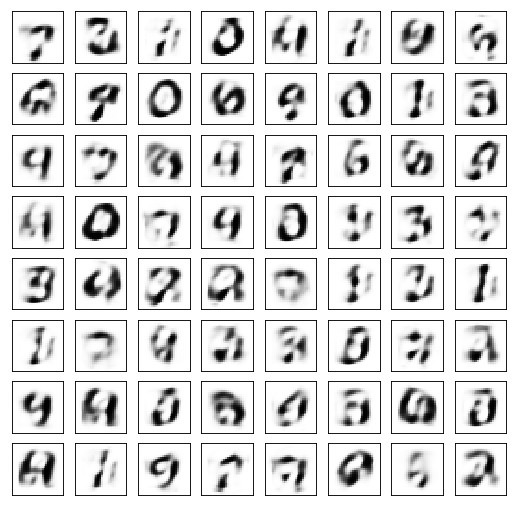

Выход декодера с единичной матрицы


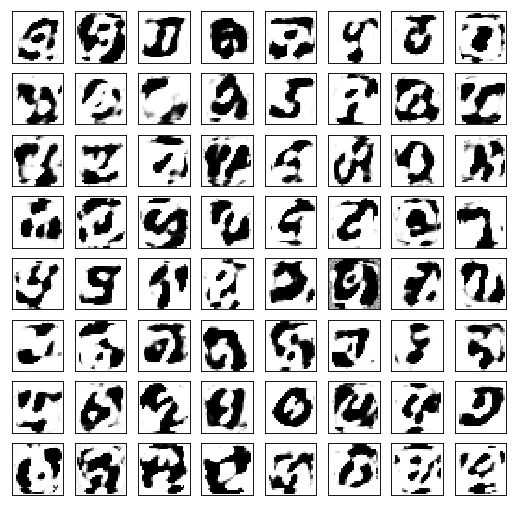

In [14]:
print ("Исходные данные")
plot_mnist(data.data.numpy(), (8, 8))
print ("Выход декодера")
plot_mnist(to_plot, (8, 8))
print ("Выход декодера с отсечкой на латентном слое")
plot_mnist(f_to_plot, (8, 8))
print ("Выход декодера с единичной матрицы")
plot_mnist(dec_to_plot, (8, 8))